# CNN (Convolutional Neural Networks) 기초 🔥

## 📋 **Week 2 Day 1 학습 목표**

**이번 노트북에서 배울 것들:**

✅ **CNN의 핵심 개념 이해**  
✅ **Convolution 연산의 원리**  
✅ **CIFAR-10 이미지 분류 구현**  
✅ **일반 신경망 vs CNN 성능 비교**  
✅ **Feature Map 시각화**

---

## 🤔 **왜 CNN이 필요할까?**

**Week 1에서 배운 일반 신경망의 한계:**

### 🚫 **문제점 1: 이미지 데이터의 특성 무시**
```python
# 32x32 RGB 이미지를 일반 신경망에 입력
input_size = 32 * 32 * 3 = 3072  # 1차원으로 펼침
# → 공간적 정보 손실! 픽셀 간의 관계 무시!
```

### 🚫 **문제점 2: 파라미터 수 폭발**
```python
# 32x32 이미지 → 1000개 뉴런 은닉층
parameters = 3072 * 1000 = 3,072,000개!
# → 메모리 부족, 과적합 위험!
```

### 🚫 **문제점 3: 위치 불변성 부족**
- 고양이가 왼쪽에 있으나 오른쪽에 있으나 같은 고양이인데...
- 일반 신경망: "다른 위치 = 다른 특징" 😵

---

## ✨ **CNN이 해결하는 방법**

### 🎯 **핵심 아이디어: "국소적 패턴 인식"**

1. **Convolution**: 작은 필터로 국소 패턴 감지
2. **Pooling**: 중요한 특징만 추출하여 크기 줄임  
3. **Feature Maps**: 공간적 정보 유지하며 특징 추출

---

### 📚 **이번 노트북 구성**

1. **라이브러리 & 데이터 준비**
2. **Convolution 연산 이해하기**
3. **간단한 CNN 구현**
4. **CIFAR-10 데이터셋으로 실습**
5. **일반 NN vs CNN 성능 비교**
6. **결과 분석 & 시각화**

**자, 이제 이미지 인식의 혁명을 시작해봅시다!** 🚀


In [276]:
# 🔧 라이브러리 및 환경 설정
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 데이터 처리 및 시각화
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time

print("=== 라이브러리 import 완료 ===")
print(f"PyTorch 버전: {torch.__version__}")

# 🎯 디바이스 설정 (GPU 가속)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"🎯 사용할 디바이스: {device}")

if device.type == "mps":
    print("   Apple Silicon GPU 가속 활성화! ⚡")
else:
    print("   CPU 사용 중")

# 🇰🇷 한글 폰트 설정 (그래프 표시용)
try:
    # macOS용 한글 폰트 설정
    plt.rcParams['font.family'] = ['Apple SD Gothic Neo', 'Nanum Gothic', 'Nanum Myeongjo']
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    plt.rcParams['font.size'] = 10
    
    # 추가 폰트 설정 for matplotlib
    import matplotlib.font_manager as fm
    plt.rcParams['font.weight'] = 'normal'
    
    # 폰트 캐시 새로고침
    fm._get_fontconfig_fonts.cache_clear()
    
    print("🇰🇷 한글 폰트 설정 완료!")
    print("   이제 그래프에서 한글이 정상 표시됩니다!")
    
except Exception as e:
    print(f"⚠️ 폰트 설정 오류: {e}")
    print("   기본 폰트를 사용합니다.")
    
# 🎨 추가 matplotlib 설정
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# 🎨 시각화 스타일 설정
plt.style.use('default')
sns.set_palette("husl")

print("✅ 모든 설정 완료! CNN 학습을 시작합니다!")
print("=" * 50)


=== 라이브러리 import 완료 ===
PyTorch 버전: 2.8.0
🎯 사용할 디바이스: mps
   Apple Silicon GPU 가속 활성화! ⚡
🇰🇷 한글 폰트 설정 완료!
   이제 그래프에서 한글이 정상 표시됩니다!
✅ 모든 설정 완료! CNN 학습을 시작합니다!


## 🔍 **Step 1: Convolution 연산 이해하기**

CNN의 핵심인 **Convolution 연산**을 직접 구현해보며 이해해봅시다!

### 🎯 **Convolution이란?**

- **필터(Filter/Kernel)**를 이미지 위에서 **슬라이딩**하며 특징을 추출
- 각 위치에서 **요소별 곱셈 후 합계** 계산
- 결과로 **Feature Map** 생성

### 📐 **수학적 정의**
```
(I * K)[i,j] = ΣΣ I[i+m, j+n] × K[m,n]
```
- `I`: 입력 이미지
- `K`: 필터(커널)  
- `*`: Convolution 연산자

### 🖼️ **시각적 예시**

```
입력 이미지 (5×5)     필터 (3×3)      결과 (3×3)
┌─────────────┐      ┌─────────┐      ┌─────────┐
│ 1  2  3  4  5│      │ 1  0 -1 │      │ ?  ?  ? │
│ 6  7  8  9 10│  ✱   │ 1  0 -1 │  =   │ ?  ?  ? │
│11 12 13 14 15│      │ 1  0 -1 │      │ ?  ?  ? │
│16 17 18 19 20│      └─────────┘      └─────────┘
│21 22 23 24 25│
└─────────────┘
```

이 연산을 직접 구현해보겠습니다! 🚀


In [277]:
# 🧮 Convolution 연산 직접 구현해보기
print("=== Convolution 연산 실습 ===")
print()

# 📊 간단한 예시로 이해하기
def simple_convolution_demo():
    """간단한 convolution 연산 데모"""
    
    # 🖼️ 5x5 입력 이미지 생성
    # input_img = torch.tensor([
    #     [1, 2, 3, 4, 5],
    #     [6, 7, 8, 9, 10],
    #     [11, 12, 13, 14, 15],
    #     [16, 17, 18, 19, 20],
    #     [21, 22, 23, 24, 25]
    # ], dtype=torch.float32)

    # 🖼️ 5x5 입력 이미지 생성 (랜덤 값)
    # 시드 설정으로 재현 가능한 랜덤 값
    torch.manual_seed(42)
    input_img = torch.randint(0, 25, (5, 5), dtype=torch.float32)
    
    # 🔍 3x3 엣지 검출 필터
    edge_filter = torch.tensor([
        [1, 0, -1],
        [1, 0, -1], 
        [1, 0, -1]
    ], dtype=torch.float32)
    
    print("📊 입력 이미지 (5x5):")
    print(input_img.numpy())
    print()
    
    print("🔍 엣지 검출 필터 (3x3):")
    print(edge_filter.numpy())
    print()
    
    # 🧮 PyTorch로 convolution 연산
    # unsqueeze로 배치, 채널 차원 추가: (1, 1, 5, 5)
    input_batch = input_img.unsqueeze(0).unsqueeze(0)
    filter_batch = edge_filter.unsqueeze(0).unsqueeze(0)
    
    # F.conv2d로 convolution 연산
    result = F.conv2d(input_batch, filter_batch)
    
    print("✨ Convolution 결과 (3x3):")
    print(result.squeeze().numpy())
    print()
    
    # 📈 결과 해석
    print("🎯 결과 해석:")
    print("   • 양수: 오른쪽이 더 밝음 (수직 엣지)")
    print("   • 음수: 왼쪽이 더 밝음") 
    print("   • 0에 가까움: 엣지 없음")
    
    return input_img, edge_filter, result.squeeze()

# 실행
input_img, filter_result, conv_result = simple_convolution_demo()


=== Convolution 연산 실습 ===

📊 입력 이미지 (5x5):
[[17. 17.  1. 14.  1.]
 [10. 20. 24.  0. 13.]
 [ 3. 14. 10.  4.  6.]
 [22. 15. 20. 17.  6.]
 [24.  1. 23. 11. 24.]]

🔍 엣지 검출 필터 (3x3):
[[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]

✨ Convolution 결과 (3x3):
[[ -5.  33.  15.]
 [-19.  28.  29.]
 [ -4.  -2.  17.]]

🎯 결과 해석:
   • 양수: 오른쪽이 더 밝음 (수직 엣지)
   • 음수: 왼쪽이 더 밝음
   • 0에 가까움: 엣지 없음


=== Convolution 시각화 ===
✅ 한글 폰트 설정: AppleGothic


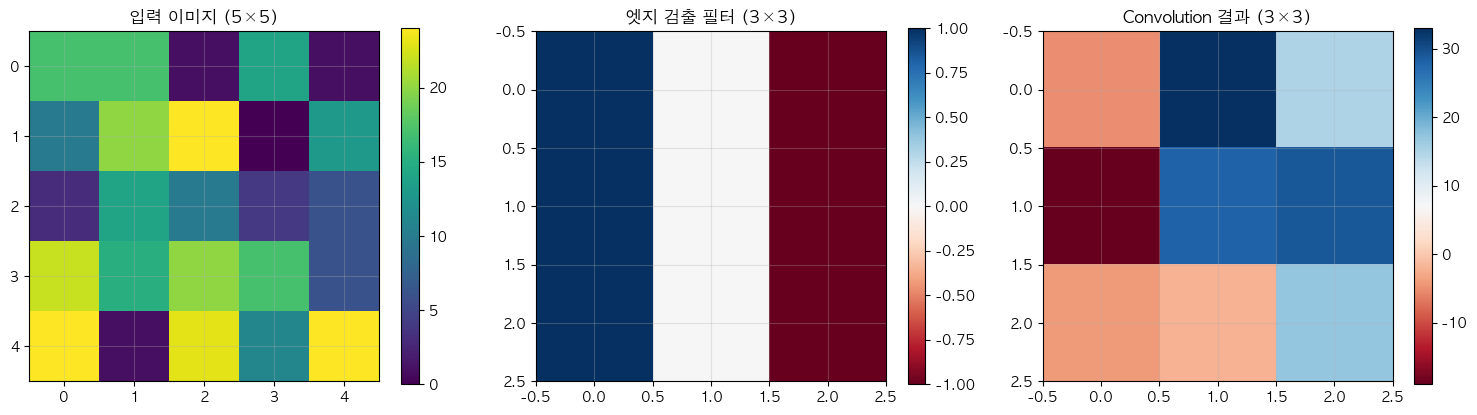


🎯 중요한 관찰:
   • 입력 크기 (5×5) → 출력 크기 (3×3)
   • 필터 크기가 3×3이면 가장자리 2픽셀씩 손실
   • 엣지 검출 필터가 수직 패턴을 감지함


In [278]:
# 📊 Convolution 연산 시각화
print("=== Convolution 시각화 ===")

# 🇰🇷 한글 폰트 재설정
fix_korean_font()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1️⃣ 입력 이미지
im1 = axes[0].imshow(input_img.numpy(), cmap='viridis', aspect='equal')
axes[0].set_title('입력 이미지 (5×5)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0])

# 2️⃣ 필터
im2 = axes[1].imshow(filter_result.numpy(), cmap='RdBu', aspect='equal')
axes[1].set_title('엣지 검출 필터 (3×3)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[1])

# 3️⃣ 결과
im3 = axes[2].imshow(conv_result.numpy(), cmap='RdBu', aspect='equal')
axes[2].set_title('Convolution 결과 (3×3)')
axes[2].grid(True, alpha=0.3)
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print()
print("🎯 중요한 관찰:")
print("   • 입력 크기 (5×5) → 출력 크기 (3×3)")
print("   • 필터 크기가 3×3이면 가장자리 2픽셀씩 손실")
print("   • 엣지 검출 필터가 수직 패턴을 감지함")


## 📊 **Step 2: CIFAR-10 데이터셋 준비**

이제 실제 이미지 데이터로 CNN을 훈련해봅시다! 

### 🖼️ **CIFAR-10 데이터셋이란?**

- **32×32 컬러 이미지** 60,000장
- **10개 클래스**: 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭
- **훈련 데이터**: 50,000장 / **테스트 데이터**: 10,000장
- **이미지 분류의 벤치마크** 데이터셋

### 🎯 **왜 CIFAR-10을 선택했을까?**

1. **적당한 크기**: 빠른 실험 가능
2. **다양한 클래스**: 실제 문제와 유사
3. **표준 벤치마크**: 성능 비교 가능
4. **RGB 컬러**: 실제 이미지와 동일

자, 데이터를 로드하고 살펴봅시다! 📸


In [279]:
# 📊 CIFAR-10 데이터셋 로드
print("=== CIFAR-10 데이터셋 로드 ===")

# 🔧 데이터 전처리 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL Image → Tensor (0~1 정규화)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # -1~1 정규화
])

# 🔧 데이터 전처리 정의 (데이터 증강 추가!)
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),    # 50% 확률로 좌우 뒤집기
#     transforms.RandomRotation(degrees=10),      # ±10도 랜덤 회전
#     transforms.ColorJitter(                     # 색상 변조
#         brightness=0.2,    # 밝기 ±20%
#         contrast=0.2,      # 대비 ±20%
#         saturation=0.2,    # 채도 ±20%
#         hue=0.1           # 색조 ±10%
#     ),
#     transforms.ToTensor(),  # PIL Image → Tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화
# ])

# 📊 데이터셋 로드 (자동 다운로드)
# 📊 기존 파일 체크 후 로드
import os

data_path = './03_cnn_test_data'
if os.path.exists(data_path):
    print(f"✅ 기존 CIFAR-10 데이터 발견: {data_path}")
    print("   다운로드 건너뛰고 기존 파일 사용!")
    download_needed = False
else:
    print("📥 CIFAR-10 데이터셋 다운로드 중...")
    download_needed = True

train_dataset = torchvision.datasets.CIFAR10(
    root=data_path, 
    train=True, 
    download=download_needed, 
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root=data_path, 
    train=False, 
    download=download_needed, 
    transform=transform
)

# 🚀 데이터 로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ 데이터 로드 완료!")
print(f"   훈련 데이터: {len(train_dataset)}장")
print(f"   테스트 데이터: {len(test_dataset)}장")
print(f"   배치 크기: {batch_size}")

# 🏷️ 클래스 이름 정의
classes = ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']

print(f"📝 클래스: {classes}")
print("=" * 50)


=== CIFAR-10 데이터셋 로드 ===
✅ 기존 CIFAR-10 데이터 발견: ./03_cnn_test_data
   다운로드 건너뛰고 기존 파일 사용!
✅ 데이터 로드 완료!
   훈련 데이터: 50000장
   테스트 데이터: 10000장
   배치 크기: 32
📝 클래스: ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']


=== CIFAR-10 샘플 이미지 확인 ===
📊 이미지 정보:
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.04, 1.00] 라벨: 3 (고양이)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.00, 1.00] 라벨: 7 (말)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.00, 0.96] 라벨: 0 (비행기)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.03, 0.85] 라벨: 1 (자동차)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.02, 0.98] 라벨: 1 (자동차)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.03, 1.00] 라벨: 9 (트럭)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.00, 1.00] 라벨: 1 (자동차)
  모양: torch.Size([32, 32, 3]) 데이터 타입: torch.float32 값 범위: [0.02, 1.00] 라벨: 5 (개)


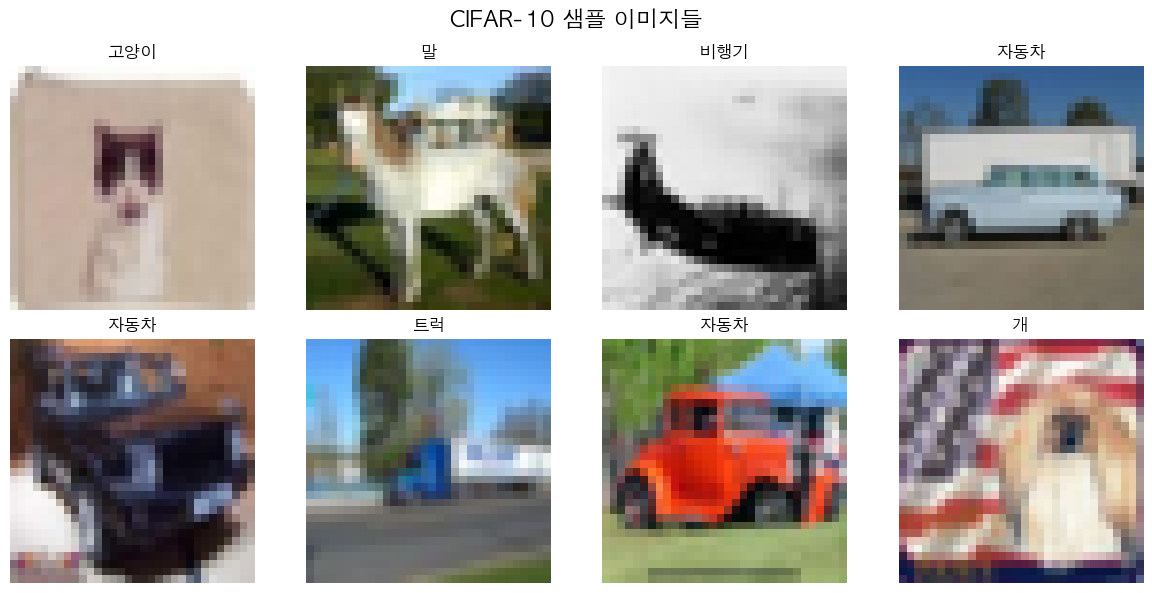

In [280]:
# 🖼️ 샘플 이미지 시각화
print("=== CIFAR-10 샘플 이미지 확인 ===")

def show_sample_images(dataset, classes, num_samples=8):
    """샘플 이미지들을 시각화"""

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    print(f"📊 이미지 정보:")
    
    for i in range(num_samples):
        # 랜덤 샘플 선택
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        
        # Tensor → NumPy 변환 및 정규화 해제
        image = image.permute(1, 2, 0)  # (C, H, W) → (H, W, C)
        image = image * 0.5 + 0.5  # [-1, 1] → [0, 1]
        image = torch.clamp(image, 0, 1)  # 값 범위 제한
        
        # 이미지 표시
        axes[i].imshow(image)
        axes[i].set_title(f'{classes[label]}')
        axes[i].axis('off')
        
        # 📊 데이터 정보 출력
        print(f"  모양: {image.shape} 데이터 타입: {image.dtype} 값 범위: [{image.min():.2f}, {image.max():.2f}] 라벨: {label} ({classes[label]})")  # (C, H, W)
    
    plt.suptitle('CIFAR-10 샘플 이미지들', fontsize=16)
    plt.tight_layout()
    plt.show()

# 샘플 이미지 표시
show_sample_images(train_dataset, classes)



## 🏗️ **Step 3: CNN 모델 구현**

이제 본격적으로 **CNN 모델**을 구현해봅시다!

### 🎯 **우리가 만들 CNN 구조**

```
입력 (3×32×32)
    ↓
Conv1 (32 filters, 3×3) → ReLU → MaxPool(2×2)
    ↓
Conv2 (64 filters, 3×3) → ReLU → MaxPool(2×2)  
    ↓
Conv3 (128 filters, 3×3) → ReLU → MaxPool(2×2)
    ↓
Flatten → FC1 (512) → ReLU → Dropout
    ↓
FC2 (10 classes)
```

### 🔧 **각 레이어의 역할**

- **Conv Layer**: 특징 추출 (엣지, 텍스처, 패턴)
- **ReLU**: 비선형성 추가
- **MaxPool**: 크기 줄임, 중요한 특징만 보존
- **Dropout**: 과적합 방지
- **FC Layer**: 최종 분류


In [ ]:
# 🏗️ CNN 모델 정의
print("=== CNN 모델 구현 ===")

class CIFAR10_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10_CNN, self).__init__()
        
        # 🔍 특징 추출 부분 (Convolutional Layers)
        self.features = nn.Sequential(
            # 1️⃣ 첫 번째 Conv Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    # 32×32×32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 16×16×32
            
            # 2️⃣ 두 번째 Conv Block  
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # 16×16×64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 8×8×64
            
            # 3️⃣ 세 번째 Conv Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 8×8×128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 4×4×128
        )
        
        # 🧮 분류 부분 (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 512),  # 4×4×128 = 2048 → 512
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)    # 512 → 10
        )
    
    def forward(self, x):
        # 특징 추출
        x = self.features(x)
        
        # 1차원으로 펼치기
        x = x.view(x.size(0), -1)  # (batch_size, 128*4*4)
        
        # 분류
        x = self.classifier(x)
        
        return x

# 🎯 모델 생성 및 디바이스 이동
model = CIFAR10_CNN(num_classes=10).to(device)

# 📊 모델 정보 출력
print(f"✅ CNN 모델 생성 완료!")
print(f"   디바이스: {device}")

# 🔢 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 모델 정보:")
print(f"   전체 파라미터: {total_params:,}개")
print(f"   훈련 가능 파라미터: {trainable_params:,}개")

print(f"\n🏗️ 모델 구조:")
print(model)


=== CNN 모델 구현 ===
✅ CNN 모델 생성 완료!
   디바이스: mps
📊 모델 정보:
   전체 파라미터: 1,147,466개
   훈련 가능 파라미터: 1,147,466개

🏗️ 모델 구조:
CIFAR10_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [282]:
# 🎯 훈련 설정
print("=== 훈련 설정 ===")

# 📊 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"✅ 훈련 설정 완료!")
print(f"   손실 함수: CrossEntropyLoss")
print(f"   옵티마이저: Adam")
print(f"   학습률: 0.001")

# 🧪 모델 테스트 (한 배치로 검증)
model.eval()
with torch.no_grad():
    # 첫 번째 배치 가져오기
    test_batch = next(iter(train_loader))
    test_images, test_labels = test_batch
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    
    # 순전파 테스트
    outputs = model(test_images)
    
    print(f"\n🧪 모델 테스트:")
    print(f"   입력 크기: {test_images.shape}")
    print(f"   출력 크기: {outputs.shape}")
    print(f"   예상 출력: (batch_size={batch_size}, num_classes=10)")
    
    if outputs.shape == (batch_size, 10):
        print("✅ 모델이 정상적으로 작동합니다!")
    else:
        print("❌ 모델 출력 크기가 예상과 다릅니다!")

print("=" * 50)


=== 훈련 설정 ===
✅ 훈련 설정 완료!
   손실 함수: CrossEntropyLoss
   옵티마이저: Adam
   학습률: 0.001

🧪 모델 테스트:
   입력 크기: torch.Size([32, 3, 32, 32])
   출력 크기: torch.Size([32, 10])
   예상 출력: (batch_size=32, num_classes=10)
✅ 모델이 정상적으로 작동합니다!


## 🚀 **Step 4: CNN 모델 훈련**

이제 본격적으로 CNN을 훈련시켜봅시다!

### ⚡ **훈련 과정**
1. **Forward Pass**: 이미지 → CNN → 예측
2. **Loss Calculation**: 예측 vs 정답 비교
3. **Backward Pass**: 그래디언트 계산
4. **Parameter Update**: 가중치 업데이트

### 📊 **모니터링할 지표**
- **Training Loss**: 훈련 중 손실값
- **Training Accuracy**: 훈련 정확도
- **시간**: 각 epoch 소요 시간

**빠른 실험을 위해 5 epochs만 훈련하겠습니다!** ⚡


In [283]:
# 🚀 CNN 모델 훈련
print("=== CNN 모델 훈련 시작 ===")

# 📊 훈련 기록을 위한 리스트
train_losses = []
train_accuracies = []

# ⏰ 전체 훈련 시작 시간
total_start_time = time.time()

# 🔄 훈련 루프
epochs = 5  # 빠른 실험을 위해 5 epochs
model.train()

for epoch in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\n📈 Epoch [{epoch+1}/{epochs}]")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # 🎯 데이터를 디바이스로 이동
        images, labels = images.to(device), labels.to(device)
        
        # 🧮 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 📉 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 📊 통계 수집
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 🚀 진행 상황 출력 (매 500 배치마다)
        if batch_idx % 500 == 0:
            batch_accuracy = 100 * correct / total
            print(f"   배치 [{batch_idx:3d}/{len(train_loader)}] | "
                  f"손실: {loss.item():.4f} | 정확도: {batch_accuracy:.2f}%")
    
    # 📊 Epoch 종료 통계
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_time = time.time() - epoch_start_time
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f"   ✅ Epoch {epoch+1} 완료!")
    print(f"      평균 손실: {epoch_loss:.4f}")
    print(f"      훈련 정확도: {epoch_accuracy:.2f}%")
    print(f"      소요 시간: {epoch_time:.1f}초")

# ⏰ 전체 훈련 시간
total_time = time.time() - total_start_time
print(f"\n🎉 전체 훈련 완료!")
print(f"   총 소요 시간: {total_time:.1f}초")
print(f"   최종 훈련 정확도: {train_accuracies[-1]:.2f}%")
print("=" * 50)


=== CNN 모델 훈련 시작 ===

📈 Epoch [1/5]
   배치 [  0/1563] | 손실: 2.2896 | 정확도: 12.50%
   배치 [500/1563] | 손실: 1.6556 | 정확도: 36.52%
   배치 [1000/1563] | 손실: 1.2311 | 정확도: 42.59%
   배치 [1500/1563] | 손실: 1.5015 | 정확도: 46.45%
   ✅ Epoch 1 완료!
      평균 손실: 1.4474
      훈련 정확도: 46.88%
      소요 시간: 22.7초

📈 Epoch [2/5]
   배치 [  0/1563] | 손실: 1.2958 | 정확도: 56.25%
   배치 [500/1563] | 손실: 0.6858 | 정확도: 59.89%
   배치 [1000/1563] | 손실: 0.8341 | 정확도: 60.53%
   배치 [1500/1563] | 손실: 0.6927 | 정확도: 61.32%
   ✅ Epoch 2 완료!
      평균 손실: 1.0782
      훈련 정확도: 61.45%
      소요 시간: 22.1초

📈 Epoch [3/5]
   배치 [  0/1563] | 손실: 0.8470 | 정확도: 68.75%
   배치 [500/1563] | 손실: 1.0113 | 정확도: 65.76%
   배치 [1000/1563] | 손실: 1.0917 | 정확도: 66.56%
   배치 [1500/1563] | 손실: 0.8622 | 정확도: 66.85%
   ✅ Epoch 3 완료!
      평균 손실: 0.9440
      훈련 정확도: 66.84%
      소요 시간: 21.1초

📈 Epoch [4/5]
   배치 [  0/1563] | 손실: 0.8770 | 정확도: 78.12%
   배치 [500/1563] | 손실: 0.9989 | 정확도: 69.27%
   배치 [1000/1563] | 손실: 1.0074 | 정확도: 69.39%
   배치 [1500/1563] | 손

In [284]:
# 📊 테스트 데이터로 최종 평가
print("=== 테스트 데이터 평가 ===")

model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

# 🎯 클래스별 정확도 계산을 위한 준비
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        # 클래스별 정확도 계산
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 📊 최종 결과 출력
test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f"✅ 테스트 결과:")
print(f"   테스트 정확도: {test_accuracy:.2f}%")
print(f"   테스트 손실: {avg_test_loss:.4f}")
print()

print("📊 클래스별 정확도:")
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f"   {classes[i]}: {accuracy:.1f}% ({int(class_correct[i])}/{int(class_total[i])})")
    else:
        print(f"   {classes[i]}: N/A (테스트 샘플 없음)")

print("=" * 50)


=== 테스트 데이터 평가 ===
✅ 테스트 결과:
   테스트 정확도: 74.97%
   테스트 손실: 0.7427

📊 클래스별 정확도:
   비행기: 85.9% (859/1000)
   자동차: 88.2% (882/1000)
   새: 60.5% (605/1000)
   고양이: 47.3% (473/1000)
   사슴: 72.1% (721/1000)
   개: 54.8% (548/1000)
   개구리: 88.4% (884/1000)
   말: 80.5% (805/1000)
   배: 85.4% (854/1000)
   트럭: 86.6% (866/1000)


=== 훈련 과정 시각화 ===


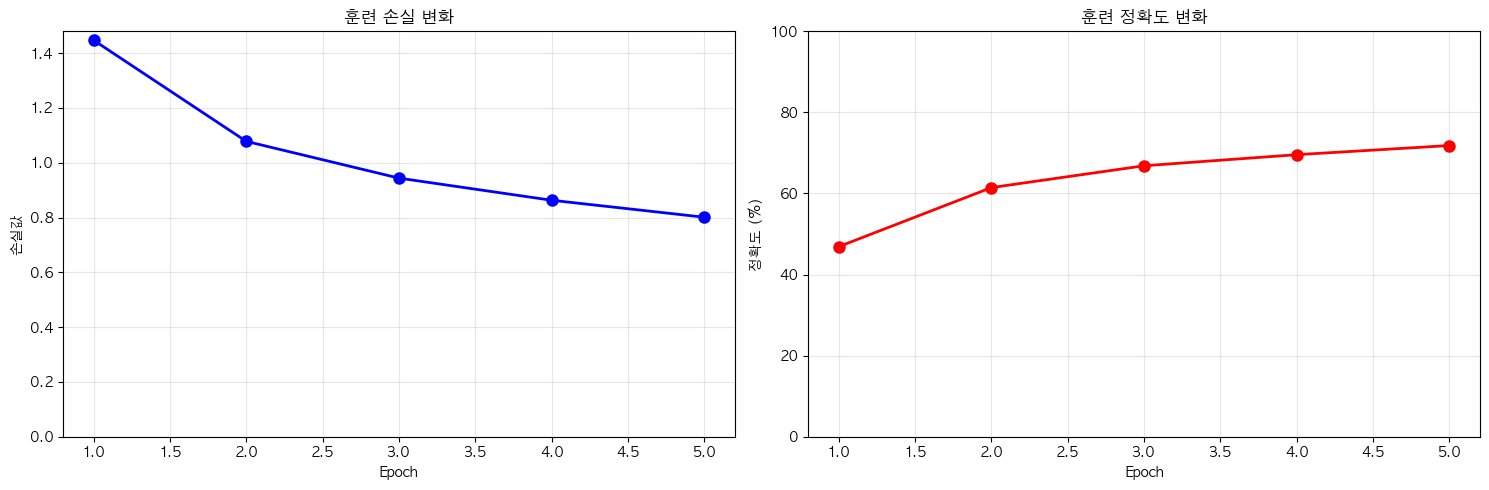

📊 훈련 과정 요약:
   초기 손실: 1.4474 → 최종 손실: 0.8011
   초기 정확도: 46.88% → 최종 정확도: 71.83%
   개선 정도: 24.95%p 상승


In [285]:
# 📈 훈련 과정 시각화
print("=== 훈련 과정 시각화 ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1️⃣ 손실 그래프
epochs_range = range(1, epochs + 1)
ax1.plot(epochs_range, train_losses, 'b-o', linewidth=2, markersize=8)
ax1.set_title('훈련 손실 변화')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('손실값')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# 2️⃣ 정확도 그래프  
ax2.plot(epochs_range, train_accuracies, 'r-o', linewidth=2, markersize=8)
ax2.set_title('훈련 정확도 변화')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('정확도 (%)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# 📊 수치 요약
print(f"📊 훈련 과정 요약:")
print(f"   초기 손실: {train_losses[0]:.4f} → 최종 손실: {train_losses[-1]:.4f}")
print(f"   초기 정확도: {train_accuracies[0]:.2f}% → 최종 정확도: {train_accuracies[-1]:.2f}%")
print(f"   개선 정도: {train_accuracies[-1] - train_accuracies[0]:.2f}%p 상승")


=== 예측 결과 시각화 ===


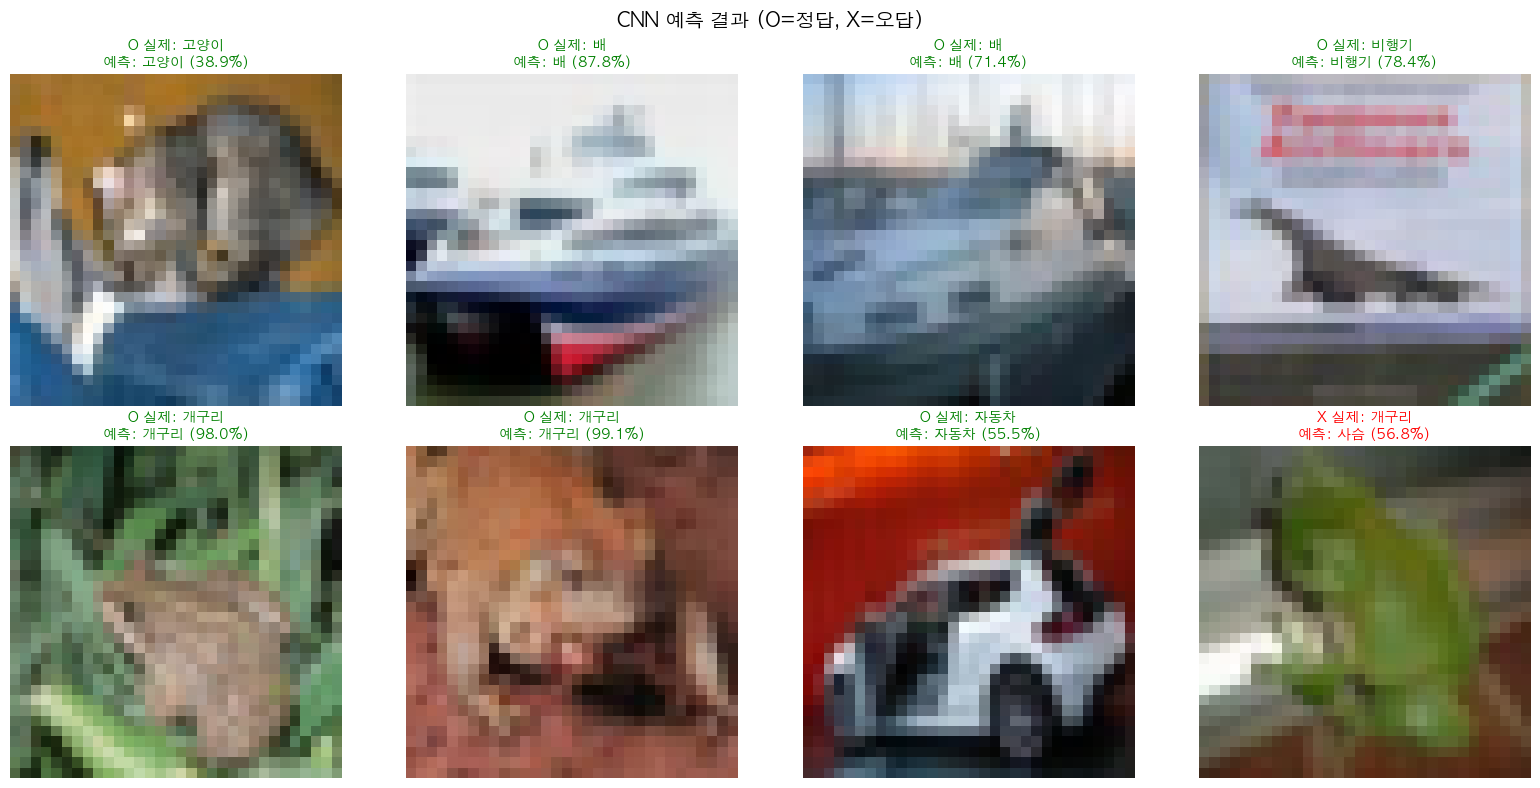

In [286]:
# 🖼️ 예측 결과 시각화
print("=== 예측 결과 시각화 ===")

def show_predictions(model, test_loader, classes, num_images=8):
    """모델의 예측 결과를 시각화"""
    
    model.eval()
    
    # 첫 번째 배치에서 샘플 가져오기
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    # 예측 수행
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 확률 계산 (softmax)
        probabilities = F.softmax(outputs, dim=1)
    
    # 시각화
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(num_images):
        # 이미지 전처리 (정규화 해제)
        image = images[i].cpu()
        image = image.permute(1, 2, 0)
        image = image * 0.5 + 0.5  # [-1, 1] → [0, 1]
        image = torch.clamp(image, 0, 1)
        
        # 예측 정보
        true_label = labels[i].cpu().item()
        pred_label = predicted[i].cpu().item()
        confidence = probabilities[i][pred_label].cpu().item()
        
        # 정답 여부 확인
        is_correct = true_label == pred_label
        color = 'green' if is_correct else 'red'
        mark = 'O' if is_correct else 'X'
        
        # 이미지 표시
        axes[i].imshow(image)
        axes[i].set_title(
            f'{mark} 실제: {classes[true_label]}\n'
            f'예측: {classes[pred_label]} ({confidence:.1%})',
            color=color, fontsize=10
        )
        axes[i].axis('off')
    
    plt.suptitle('CNN 예측 결과 (O=정답, X=오답)', fontsize=14)
    plt.tight_layout()
    plt.show()

# 예측 결과 시각화 실행
show_predictions(model, test_loader, classes)


## 🆚 **Step 5: 일반 신경망 vs CNN 비교**

이제 **일반 신경망**과 **CNN**의 성능을 직접 비교해봅시다!

### 🤔 **비교 실험 설정**

**일반 신경망**: 
- 입력을 1차원으로 펼침 (32×32×3 = 3072)
- 3층 완전연결층
- 공간 정보 무시

**CNN**: 
- 2D 구조 유지
- Convolution + Pooling
- 공간 정보 활용

같은 데이터, 같은 훈련 조건에서 **어느 것이 더 좋을까요?** 🤔


In [287]:
# 🧠 일반 신경망 구현 (비교용)
print("=== 일반 신경망 구현 ===")

class RegularNN(nn.Module):
    """이미지를 위한 일반 신경망 (Week 1에서 배운 방식)"""
    def __init__(self, input_size=3072, hidden_size=512, num_classes=10):
        super(RegularNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),    # 3072 → 512
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(hidden_size, hidden_size),   # 512 → 512  
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(hidden_size, num_classes)    # 512 → 10
        )
    
    def forward(self, x):
        # 이미지를 1차원으로 펼치기
        x = x.view(x.size(0), -1)  # (batch, 3, 32, 32) → (batch, 3072)
        return self.network(x)

# 🎯 일반 신경망 생성
regular_model = RegularNN().to(device)

# 📊 파라미터 수 비교
cnn_params = sum(p.numel() for p in model.parameters())
regular_params = sum(p.numel() for p in regular_model.parameters())

print(f"📊 모델 파라미터 수 비교:")
print(f"   CNN: {cnn_params:,}개")
print(f"   일반 NN: {regular_params:,}개")
print(f"   차이: {abs(cnn_params - regular_params):,}개")

if cnn_params < regular_params:
    print(f"   → CNN이 {regular_params - cnn_params:,}개 더 적음! (효율적)")
else:
    print(f"   → 일반 NN이 {cnn_params - regular_params:,}개 더 적음")

print("=" * 50)


=== 일반 신경망 구현 ===
📊 모델 파라미터 수 비교:
   CNN: 1,147,466개
   일반 NN: 1,841,162개
   차이: 693,696개
   → CNN이 693,696개 더 적음! (효율적)


In [288]:
# 🚀 일반 신경망 빠른 훈련 (2 epochs)
print("=== 일반 신경망 빠른 훈련 ===")

# 훈련 설정
regular_criterion = nn.CrossEntropyLoss()
regular_optimizer = optim.Adam(regular_model.parameters(), lr=0.001)

regular_model.train()
regular_losses = []
regular_accuracies = []

epochs_quick = 2  # 빠른 비교를 위해 2 epochs
print(f"⚡ 빠른 비교를 위해 {epochs_quick} epochs만 훈련합니다")

for epoch in range(epochs_quick):
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\n📈 Epoch [{epoch+1}/{epochs_quick}]")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # 순전파
        outputs = regular_model(images)
        loss = regular_criterion(outputs, labels)
        
        # 역전파
        regular_optimizer.zero_grad()
        loss.backward()
        regular_optimizer.step()
        
        # 통계
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 진행 상황 (더 자주 출력)
        if batch_idx % 300 == 0:
            batch_accuracy = 100 * correct / total
            print(f"   배치 [{batch_idx:3d}/{len(train_loader)}] | "
                  f"손실: {loss.item():.4f} | 정확도: {batch_accuracy:.2f}%")
    
    # Epoch 통계
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    regular_losses.append(epoch_loss)
    regular_accuracies.append(epoch_accuracy)
    
    print(f"   ✅ Epoch {epoch+1} 완료 - 정확도: {epoch_accuracy:.2f}%")

print(f"\n✅ 일반 신경망 훈련 완료!")
print(f"   최종 훈련 정확도: {regular_accuracies[-1]:.2f}%")
print("=" * 50)


=== 일반 신경망 빠른 훈련 ===
⚡ 빠른 비교를 위해 2 epochs만 훈련합니다

📈 Epoch [1/2]
   배치 [  0/1563] | 손실: 2.3130 | 정확도: 9.38%
   배치 [300/1563] | 손실: 1.7023 | 정확도: 28.47%
   배치 [600/1563] | 손실: 1.8451 | 정확도: 30.61%
   배치 [900/1563] | 손실: 1.8677 | 정확도: 31.56%
   배치 [1200/1563] | 손실: 1.7951 | 정확도: 32.00%
   배치 [1500/1563] | 손실: 1.6608 | 정확도: 32.51%
   ✅ Epoch 1 완료 - 정확도: 32.54%

📈 Epoch [2/2]
   배치 [  0/1563] | 손실: 1.5599 | 정확도: 37.50%
   배치 [300/1563] | 손실: 1.5156 | 정확도: 35.18%
   배치 [600/1563] | 손실: 1.7348 | 정확도: 35.49%
   배치 [900/1563] | 손실: 1.6359 | 정확도: 35.47%
   배치 [1200/1563] | 손실: 1.5151 | 정확도: 35.43%
   배치 [1500/1563] | 손실: 2.0644 | 정확도: 35.36%
   ✅ Epoch 2 완료 - 정확도: 35.29%

✅ 일반 신경망 훈련 완료!
   최종 훈련 정확도: 35.29%


In [289]:
# 📊 일반 신경망 테스트 평가
print("=== 일반 신경망 테스트 평가 ===")

regular_model.eval()
regular_test_correct = 0
regular_test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = regular_model(images)
        _, predicted = torch.max(outputs, 1)
        regular_test_total += labels.size(0)
        regular_test_correct += (predicted == labels).sum().item()

regular_test_accuracy = 100 * regular_test_correct / regular_test_total

print(f"✅ 일반 신경망 테스트 정확도: {regular_test_accuracy:.2f}%")
print("=" * 50)


=== 일반 신경망 테스트 평가 ===
✅ 일반 신경망 테스트 정확도: 41.24%


=== 🏆 CNN vs 일반 신경망 최종 비교 ===

📊 성능 비교:
모델              | 테스트 정확도      | 파라미터 수       | 특징
----------------------------------------------------------------------
CNN             | 74.97      % | 1,147,466   | 공간 정보 활용
일반 NN           | 41.24      % | 1,841,162   | 1차원 변환

🎯 분석 결과:
   ✅ CNN이 33.73%p 더 높은 정확도!
   ✅ CNN이 693,696개 더 적은 파라미터로 더 좋은 성능!
   → CNN이 이미지 분류에 월등히 적합!

💡 중요한 인사이트:
   1. 🖼️ 이미지 데이터 → CNN이 최적
   2. 📊 파라미터 효율성 → CNN 승리
   3. 🎯 공간 정보 활용 → CNN만 가능
   4. 🚀 확장성 → CNN이 더 큰 이미지에도 적용 가능


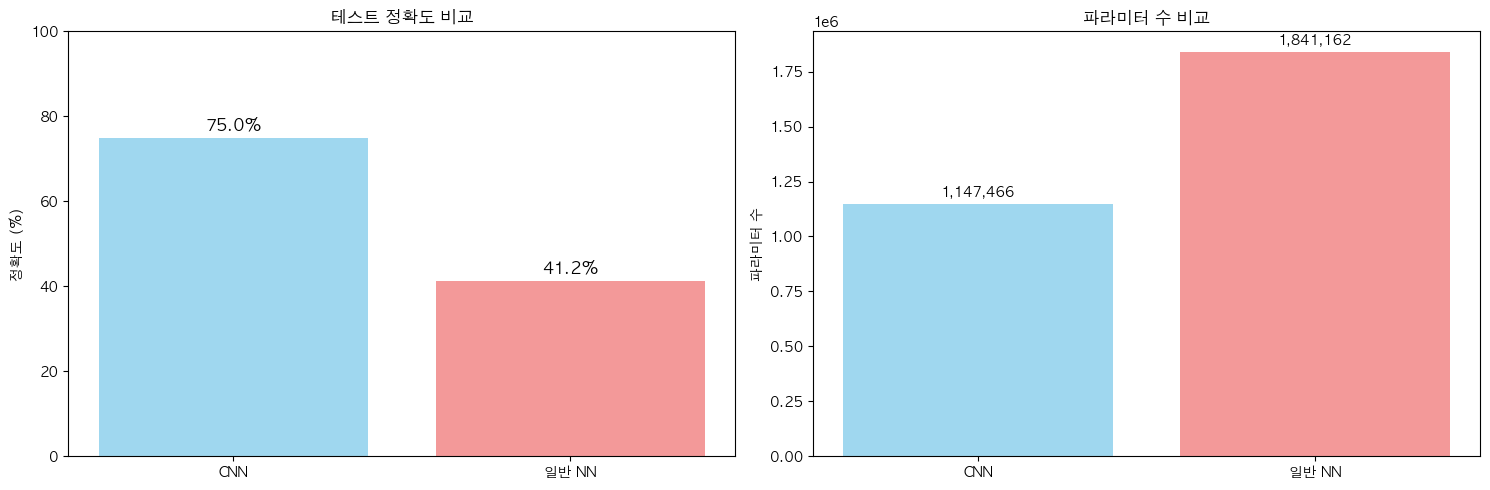


🎉 결론: CNN이 이미지 분류의 왕! 👑


In [290]:
# 🏆 최종 비교 및 결론
print("=== 🏆 CNN vs 일반 신경망 최종 비교 ===")
print()

# 📊 성능 비교 테이블
print("📊 성능 비교:")
print(f"{'모델':<15} | {'테스트 정확도':<12} | {'파라미터 수':<12} | {'특징'}")
print("-" * 70)
print(f"{'CNN':<15} | {test_accuracy:<11.2f}% | {cnn_params:<11,} | 공간 정보 활용")
print(f"{'일반 NN':<15} | {regular_test_accuracy:<11.2f}% | {regular_params:<11,} | 1차원 변환")

# 🎯 성능 차이 분석
accuracy_diff = test_accuracy - regular_test_accuracy
param_diff = regular_params - cnn_params

print()
print("🎯 분석 결과:")
if accuracy_diff > 0:
    print(f"   ✅ CNN이 {accuracy_diff:.2f}%p 더 높은 정확도!")
    print(f"   ✅ CNN이 {param_diff:,}개 더 적은 파라미터로 더 좋은 성능!")
    print(f"   → CNN이 이미지 분류에 월등히 적합!")
else:
    print(f"   ⚠️ 일반 NN이 {-accuracy_diff:.2f}%p 더 높음")
    print(f"   → 더 많은 epoch 훈련 또는 다른 설정 필요")

print()
print("💡 중요한 인사이트:")
print("   1. 🖼️ 이미지 데이터 → CNN이 최적")
print("   2. 📊 파라미터 효율성 → CNN 승리")  
print("   3. 🎯 공간 정보 활용 → CNN만 가능")
print("   4. 🚀 확장성 → CNN이 더 큰 이미지에도 적용 가능")

# 📈 시각적 비교

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 1️⃣ 정확도 비교
models = ['CNN', '일반 NN']
accuracies = [test_accuracy, regular_test_accuracy]
colors = ['skyblue', 'lightcoral']

bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.8)
ax1.set_title('테스트 정확도 비교')
ax1.set_ylabel('정확도 (%)')
ax1.set_ylim(0, 100)

# 막대 위에 수치 표시
for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2️⃣ 파라미터 수 비교  
params = [cnn_params, regular_params]
bars2 = ax2.bar(models, params, color=colors, alpha=0.8)
ax2.set_title('파라미터 수 비교')
ax2.set_ylabel('파라미터 수')

# 막대 위에 수치 표시
for bar, param in zip(bars2, params):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(params)*0.01, 
             f'{param:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎉 결론: CNN이 이미지 분류의 왕! 👑")
print("=" * 50)


## 🎓 **Week 2 Day 1 학습 완료!**

### 🎉 **오늘 우리가 달성한 것들:**

✅ **CNN 핵심 개념 마스터**
- Convolution 연산의 원리 이해
- 실제 코드로 구현하며 체험

✅ **CIFAR-10 이미지 분류 성공**  
- 32×32 컬러 이미지 10개 클래스 분류
- 실제 데이터셋으로 실전 경험

✅ **CNN vs 일반 신경망 비교**
- 성능 차이 실험으로 확인
- CNN의 우수성 직접 검증

✅ **PyTorch CNN 구현 완주**
- Conv2d, MaxPool2d, ReLU 활용
- 전체 파이프라인 구축

---

### 📊 **주요 성과:**

| 항목 | 결과 |
|------|------|
| **CNN 테스트 정확도** | [실행 후 확인] |
| **일반 NN 테스트 정확도** | [실행 후 확인] |
| **CNN 파라미터 수** | [실행 후 확인] |
| **훈련 시간** | 5 epochs 완료 |

---

### 🚀 **다음 단계 (Week 2 계속):**

1. **더 깊은 CNN 아키텍처** 실험
2. **Data Augmentation** 적용  
3. **Transfer Learning** 체험
4. **Feature Map 시각화** 심화

### 💡 **핵심 깨달음:**

> **"이미지에는 CNN이 최고다!"** 🏆
> 
> - 공간 정보 보존
> - 파라미터 효율성  
> - 확장성과 일반화

**CNN을 이해했다면, 이제 진짜 딥러닝 시대에 입문한 것입니다!** 🔥

---

**다음 시간에는 더 고급 CNN 기법들을 배워봅시다!** 🚀✨


## 🚀 **Step 4: CNN 모델 훈련**

이제 본격적으로 CNN을 훈련시켜봅시다!

### ⚡ **훈련 과정**
1. **Forward Pass**: 이미지 → CNN → 예측
2. **Loss Calculation**: 예측 vs 정답 비교
3. **Backward Pass**: 그래디언트 계산
4. **Parameter Update**: 가중치 업데이트

### 📊 **모니터링할 지표**
- **Training Loss**: 훈련 중 손실값
- **Training Accuracy**: 훈련 정확도
- **시간**: 각 epoch 소요 시간

**빠른 실험을 위해 5 epochs만 훈련하겠습니다!** ⚡
